In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from scipy.optimize import curve_fit

In [2]:
def gaussian(x, amplitude, mean, std_dev, offset):
    return amplitude * np.exp(-(x - mean)**2 / (2 * std_dev**2)) + offset

In [10]:
for file in Path('opa_spectrum').glob("*.dat"):
    print(file.name)

wl_500_HR2001601_0.dat
wl_510_HR2001601_0.dat
wl_525_HR2001601_0.dat
wl_535_HR2001601_0.dat
wl_540_HR2001601_0.dat
wl_520_HR2001601_0.dat
wl_530_HR2001601_0.dat


In [16]:
data = {}
for file in Path('opa_spectrum').glob("*.dat"):

    # Read lines starting from line 15
    with open(file, 'r') as f:
        array_from_file = np.loadtxt(f, skiprows=14)
    data[int(file.name[3:6])] = array_from_file

[1.38605587e+02 9.47299095e-03 1.19340871e-02 7.93677025e+01]
[7.70476815e+01 1.40346078e-02 1.86799253e-02 4.94308597e+01]
[1.77781739e+02 8.05308552e-03 9.74172803e-03 9.19568024e+01]
[1.54647435e+02 7.35106538e-03 8.91296815e-03 8.05268560e+01]
[3.19814512e+02 8.19513175e-03 9.53236120e-03 1.46658589e+02]
[7.04766417e+01 5.67463934e-03 7.43626943e-03 4.38757883e+01]
[7.72533317e+01 4.89346325e-03 5.64097974e-03 3.43524027e+01]


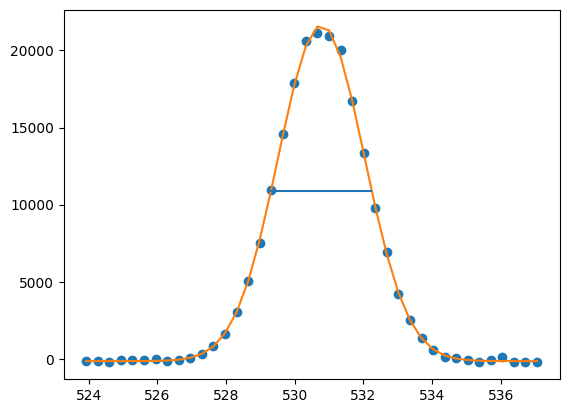

In [25]:
res = {}
for wl in data.keys():
    y_max = np.max(data[wl].T[1])
    i_max = np.argmax(data[wl].T[1])
    d = data[wl][i_max-20:i_max+20].T
    x, y = d[0], d[1]
    x_max = x[np.argmax(y)]
    params, covariance = curve_fit(gaussian, x, y, p0=[y_max, x_max, 2.0, -100.0])
    amplitude, mean, std_dev, offset = params
    fwhm = 2*np.sqrt(2*np.log(2)) * std_dev
    plt.clf()
    plt.plot(x, y, 'o')
    plt.plot(x, gaussian(x, amplitude, mean, std_dev, offset), '-')
    plt.hlines(amplitude / 2, mean - fwhm / 2, mean + fwhm / 2)
    plt.savefig(Path('opa_spectrum').joinpath(f"{wl}_nm_spectrum.png"))
    print(np.sqrt(np.diag(covariance)))
    res[wl] = {
        "mean": mean, 
        "mean_err": np.sqrt(np.diag(covariance))[1], 
        "bandwidth": fwhm, 
        "bw_err": np.sqrt(np.diag(covariance))[2]
    }
res = dict(sorted(res.items()))

In [19]:
def pulse_duration(wavelength, bandwidth):
    return 0.4416 * wavelength**2 / (bandwidth * 100 * 2.99792458)

In [26]:
res

{500: {'mean': 501.6282711009998,
  'mean_err': 0.009472990953651497,
  'bandwidth': 3.8292329835927443,
  'bw_err': 0.011934087129968698},
 510: {'mean': 510.16322218304975,
  'mean_err': 0.014034607840569688,
  'bandwidth': 4.204001720846648,
  'bw_err': 0.018679925341308957},
 520: {'mean': 520.5258031939668,
  'mean_err': 0.0056746393420349876,
  'bandwidth': 4.095740925542866,
  'bw_err': 0.007436269429541245},
 525: {'mean': 527.3391758193088,
  'mean_err': 0.008053085523893956,
  'bandwidth': 3.471673468679192,
  'bw_err': 0.009741728031596368},
 530: {'mean': 530.7781037515015,
  'mean_err': 0.004893463247208869,
  'bandwidth': 2.963395120805963,
  'bw_err': 0.005640979742040955},
 535: {'mean': 536.025031263785,
  'mean_err': 0.007351065381079256,
  'bandwidth': 3.489056385225438,
  'bw_err': 0.00891296815027938},
 540: {'mean': 540.5972087996629,
  'mean_err': 0.008195131749659393,
  'bandwidth': 3.0608698363226368,
  'bw_err': 0.009532361198067248}}

In [21]:
t_pulse = {}
for wl in res:
    t_pulse[wl] = pulse_duration(res[wl]["mean"], res[wl]["bandwidth"])  # fs

In [22]:
t_pulse

{500: 96.79670638861498,
 510: 91.19347614946551,
 525: 117.99118518659529,
 535: 121.3027133559515,
 540: 140.64072556497126,
 520: 97.4451907352194,
 530: 140.0376446032355}

In [27]:
from uncertainties import ufloat
t_pulse = {}
for wl in res:
    t_pulse[wl] = pulse_duration(ufloat(res[wl]["mean"],res[wl]["mean_err"]), ufloat(res[wl]["bandwidth"],res[wl]["bw_err"])) 

In [28]:
t_pulse

{500: 96.79670638861498+/-0.3016962292403416,
 510: 91.19347614946551+/-0.4052372071279954,
 520: 97.4451907352194+/-0.176935249305744,
 525: 117.99118518659529+/-0.3311100919560846,
 530: 140.0376446032355+/-0.26658158743921617,
 535: 121.3027133559515+/-0.3098916781777724,
 540: 140.64072556497126+/-0.4380133092015035}